In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from tqdm import tqdm_notebook
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('train.csv')
label = pd.read_csv('train_label.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

# 数据探索

In [3]:
df_source = train.merge(label,on='ID',how='left')

# 特征工程

In [4]:
test['label'] = -1
train = train.merge(label,on='ID',how='left')
data = pd.concat([train, test])

In [5]:
def get_time_fe(df):
    df['day'] = df.date.apply(lambda x:int(x[8:10]))

    df['hour'] = df.date.apply(lambda x:int(x[11:13]))
    
#     df['d_h'] = df['day'].astype('int')*24+df['hour'].astype('int')
    
#     result = df[df['label']!=-1].groupby(['d_h']).label.agg(['count','sum']).reset_index()
    
#     result['click_prob'] = (result['sum'].astype('int')/result['count'].astype('int'))
    
#     df = df.merge(result,on=['d_h'],how = 'left')
    
#     del result['count'],result['sum'],result['d_h']
    
    return df

In [6]:
# szy = get_time_fe(data)
# result = szy[szy['label']!=-1].groupby(['hour']).label.agg(['count','sum']).reset_index()
# result['click_prob'] = (result['sum'].astype('int')/result['count'].astype('int'))

In [7]:
#对时间分箱
def getSeg(x):
    if x >=0 and x<= 3:
        return 1
    elif x>=4 and x<=12:
        return 2
    elif x>=13 and x<=18:
        return 3
    elif x>=19 and x<=23:
        return 1

In [8]:
# hourDF = train_df.groupby(['hour', 'label'])['hour'].count().unstack('label').fillna(0)
# hourDF[[0,1]].plot(kind='bar', stacked=True);

In [9]:
#count统计特征
cross_feature = []
def get_cross_fe(df):
    first_feature = [ 'B2', 'B3']
    second_feature = ['C1','C2','C3','D1','A1','A2','A3']
    for feat_1 in first_feature:
        for feat_2 in second_feature:
            col_name = "cross_" + feat_1 + "_and_" + feat_2
            cross_feature.append(col_name)
            df[col_name] = df[feat_1].astype(str).values + '_' + df[feat_2].astype(str).values
    return df

In [10]:
#获取nunique特征
def get_nunique_1_fe(df):
    adid_nuq = [ 'hour','E1','E14','B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A2')[feat].nunique().reset_index().rename(columns={feat: "A2_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A2'].nunique().reset_index().rename(columns={'A2': "%s_A2_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A2'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df
def get_nunique_2_fe(df):
    adid_nuq = [ 'E1','E14']
    for feat in adid_nuq:
        gp1 = df.groupby('hour')[feat].nunique().reset_index().rename(columns={feat: "hour_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['hour'].nunique().reset_index().rename(columns={'hour': "%s_hour_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['hour'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

# def get_nunique_3_fe(df):
#     adid_nuq = ['B2','B3']
#     for feat in adid_nuq:
#         gp1 = df.groupby('A3')[feat].nunique().reset_index().rename(columns={feat: "A3_%s_nuq_num" % feat})
#         gp2 = df.groupby(feat)['A3'].nunique().reset_index().rename(columns={'A3': "%s_A3_nuq_num" % feat})
#         df = pd.merge(df, gp1, how='left', on=['A3'])
#         df = pd.merge(df, gp2, how='left', on=[feat])
#     return df

def get_nunique_4_fe(df):
    adid_nuq = [ 'B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A1')[feat].nunique().reset_index().rename(columns={feat: "A1_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A1'].nunique().reset_index().rename(columns={'A1': "%s_A1_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A1'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

In [11]:
data = get_time_fe(data)
# data['hour_seg'] = data['hour'].apply(lambda x: getSeg(x))
data = get_cross_fe(data)
data = get_nunique_1_fe(data)
data = get_nunique_2_fe(data)
# data = get_nunique_3_fe(data)
# data = get_nunique_4_fe(data)

In [12]:
len(cross_feature)

14

In [13]:
#labelencoder()
cate_feature = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','E2','E3','E5','E7','E9','E10','E13','E16','E17','E19','E21','E22']
# cross_feature = cross_feature[:15]
cate_features = cate_feature+cross_feature
for item in cate_features:
    data[item] = LabelEncoder().fit_transform(data[item])

In [14]:
def feature_count(data, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    return data

for i in cross_feature:
    n = data[i].nunique()
    if n > 5:
        data = feature_count(data, [i])
    else:
        print(i, ':', n)

In [15]:
#ratio：类别偏好的ratio比例特征
label_feature =[ 'A2', 'A3','hour']
data_temp = data[label_feature]
df_feature = pd.DataFrame()
data_temp['cnt'] = 1
print('Begin ratio clcik...')
col_type = label_feature.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_click_of_" + col_type[i]
    df_feature[col_name] = (
                    data_temp[col_type[i]].map(data_temp[col_type[i]].value_counts()) / len(data) * 100).astype(int)            
data = pd.concat([data, df_feature], axis=1)
print('The end')

Begin ratio clcik...
The end


In [61]:
train_df = data[data['label'] != -1]
test_df = data[data['label'] == -1]

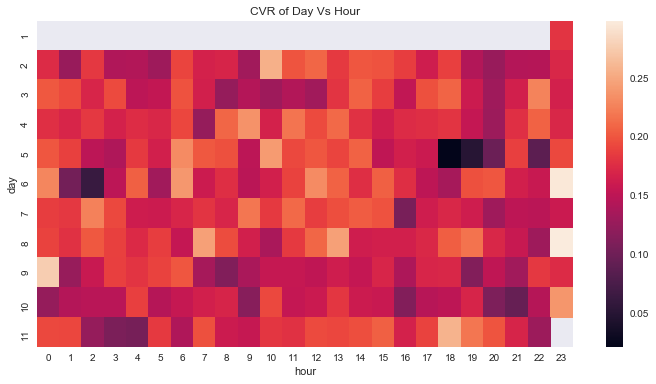

In [37]:
# grouped_df = train_df.groupby(["day", "hour"])["label"].aggregate("mean").reset_index()
# grouped_df = grouped_df.pivot('day', 'hour', 'label')
# plt.figure(figsize=(12,6))
# sns.heatmap(grouped_df)
# plt.title("CVR of Day Vs Hour")
# plt.show()

In [17]:
# sns.stripplot(train_df["label"],train_df["A3"],jitter=True,order=None)
# plt.title("click Vs creative_height");

# 删除不需要的字段

In [63]:
## get train feature
del_feature = ['ID','day','date','label','D2']+cross_feature
features = [i for i in train_df.columns if i not in del_feature]

In [64]:
train_x = train_df[features]
train_y = train_df['label'].values
test = test_df[features]

In [65]:
# params= {
#    'num_leaves':97,
#     'objective':'binary',
#     'learning_rate':0.02,
#    'max_bin':400,
#    'min_data_in_leaf':10,
#     'feature_fraction':0.164,
#     'subsample':0.8,
#     'subsample_freq':1,
#    'bagging_freq':1,
#    'bagging_seed':0,
#     'min_split_gain':0.000135,
#     'min_child_weight':5,
#     'min_child_samples':30,
#     'bagging_fraction':1,
#     'metric': {'binary_logloss', 'auc'},

#    'reg_alpha':3,
#    'reg_lambda':5
# }

# 训练参数的选取

In [66]:
params= {
   'num_leaves':97,
    'objective':'binary',
    'learning_rate':0.02,
   'max_bin':400,
   'min_data_in_leaf':10,
    'feature_fraction':0.164,
    'subsample':0.8,
    'subsample_freq':1,
   'bagging_freq':1,
   'bagging_seed':0,
    'min_split_gain':0.000135,
    'min_child_weight':5,
    'min_child_samples':30,
    'bagging_fraction':1,
    'metric': {'binary_logloss', 'auc'},

   'reg_alpha':3,
   'reg_lambda':0
}

# 五折交叉

In [67]:
n_splits=10
folds = KFold(n_splits=n_splits, shuffle=True, random_state=2048)
prob_oof = np.zeros((train_x.shape[0], ))
test_pred_prob = np.zeros((test.shape[0], ))

In [68]:
num_round = 1000
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round=2048,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    categorical_feature=cate_feature,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold 1
Training until validation scores don't improve for 60 rounds.
[200]	training's binary_logloss: 0.38134	training's auc: 0.791771	valid_1's binary_logloss: 0.405036	valid_1's auc: 0.732941
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.377976	training's auc: 0.797011	valid_1's binary_logloss: 0.404867	valid_1's auc: 0.733224
fold 2
Training until validation scores don't improve for 60 rounds.
[200]	training's binary_logloss: 0.381032	training's auc: 0.793035	valid_1's binary_logloss: 0.407363	valid_1's auc: 0.72341
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.38308	training's auc: 0.790009	valid_1's binary_logloss: 0.407372	valid_1's auc: 0.723586
fold 3
Training until validation scores don't improve for 60 rounds.
[200]	training's binary_logloss: 0.381147	training's auc: 0.790762	valid_1's binary_logloss: 0.410154	valid_1's auc: 0.738074
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.369175	training's auc: 0.8

KeyboardInterrupt: 

# roc评估

In [ ]:
score=roc_auc_score(train_y,prob_oof)
score

In [ ]:
sub['label'] = test_pred_prob

In [ ]:
sub['label'] = sub['label'].apply(lambda x:'%.2f'%x)

In [ ]:
sub.to_csv('C:/Users/DELL/Desktop/sub/'+str('%.6f'%score)+'lgb_'+str(n_splits)+'.csv',encoding='utf-8',index=False)

# feature_importance展示

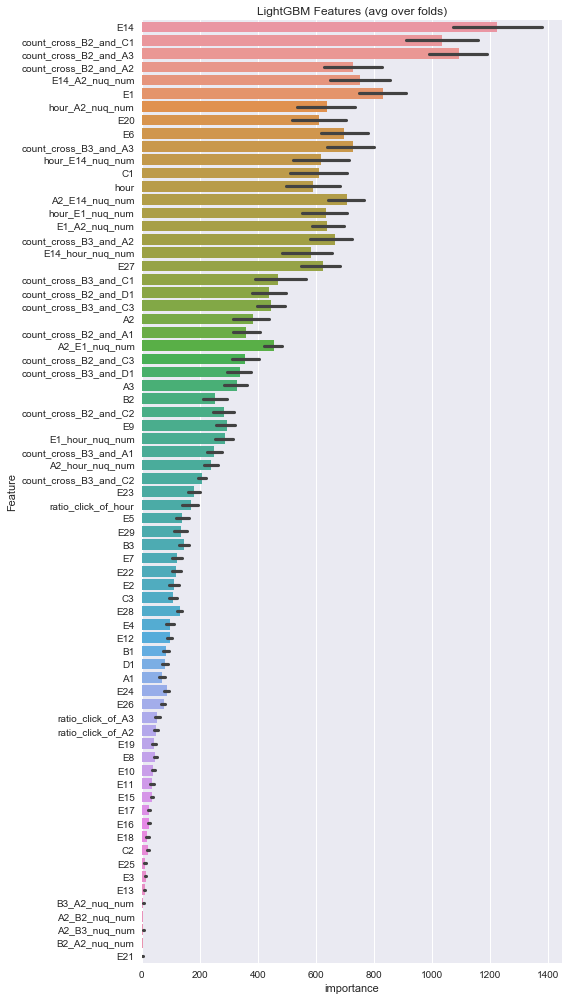

In [28]:
## plot feature importance
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)].sort_values(by='importance',ascending=False)
plt.figure(figsize=(8, 14))
sns.barplot(y="Feature",
            x="importance",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [29]:
# def get_more_fe(df):
#     uniq_list = ['C1','E14','A2','E1','E27']
#     for i in uniq_list:
#         tmp = df.groupby(['hour'])[i].nunique().reset_index(name = i+'_h_uniq')
#         df  = df.merge(tmp, on=['hour'], how='left')
#         tmp1 = df.groupby(['date'])[i].nunique().reset_index(name = i+'_d_uniq')
#         df  = df.merge(tmp1, on=['date'], how='left')
#     dev_list = ['D1','D2']
#     for i in dev_list:
#         tmp = df.groupby(['C1'])[i].nunique().reset_index(name = i+'_C1_de_uniq')
#         df  = df.merge(tmp, on=['C1'], how='left')
#         tmp1 = df.groupby(['C2'])[i].nunique().reset_index(name = i+'_C2_de_uniq')
#         df  = df.merge(tmp1, on=['C2'], how='left')
#         tmp2 = df.groupby(['C3'])[i].nunique().reset_index(name = i+'_C3_de_uniq')
#         df  = df.merge(tmp2, on=['C3'], how='left')
#     return df

In [30]:

# params= {
#    'num_leaves':97,
#     'objective':'binary',
#     'learning_rate':0.02,
#    'max_bin':400,
#    'min_data_in_leaf':10,
#     'feature_fraction':0.164,
#     'subsample':0.8,
#     'subsample_freq':1,
#    'bagging_freq':1,
#    'bagging_seed':0,
#     'min_split_gain':0.000135,
#     'min_child_weight':5,
#     'min_child_samples':30,
#     'bagging_fraction':1,
#     'metric': {'binary_logloss', 'auc'},

#    'reg_alpha':3,
#    'reg_lambda':0
# }